In [1]:
import os
import pandas as pd
import ast


In [2]:
attractions = pd.read_csv(r'D:\final_project\preprocessing\datasets\raw\tourist_attraction.csv')
descriptions = pd.read_csv(r'D:\final_project\preprocessing\datasets\raw\description.csv')
transport = pd.read_csv(r'D:\final_project\preprocessing\datasets\raw\new_transportation.csv')
reviews = pd.read_csv(r'D:\final_project\preprocessing\datasets\raw\reviews.csv')
hotels = pd.read_csv(r'D:\final_project\preprocessing\datasets\raw\hotels.csv')
restaurants = pd.read_csv(r'D:\final_project\preprocessing\datasets\raw\restaurants.csv')
events = pd.read_csv(r'D:\final_project\preprocessing\datasets\raw\events.csv')

In [3]:
def clean_columns(df):
    df.columns = (
        df.columns
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("/", "_")
        .str.replace("(", "")
        .str.replace(")", "")
    )
    return df

attractions  = clean_columns(attractions)
descriptions = clean_columns(descriptions)
transport    = clean_columns(transport)
hotels       = clean_columns(hotels)
restaurants  = clean_columns(restaurants)
events       = clean_columns(events)
reviews      = clean_columns(reviews)


In [4]:
def clean_text(col):
    return col.str.lower().str.strip()

# attraction names
attractions['destination']  = clean_text(attractions['destination'])
descriptions['destination'] = clean_text(descriptions['destination'])
transport['name']           = clean_text(transport['name'])
hotels['attraction']        = clean_text(hotels['attraction'])
restaurants['attraction']   = clean_text(restaurants['attraction'])
events['attraction']        = clean_text(events['attraction'])
reviews['location'] = clean_text(reviews['location'])


In [5]:
# STEP 2: CLEAN TEXT VALUES (MERGE KEYS)
# -----------------------------
def clean_text(col):
    return col.str.lower().str.strip()

# attraction names
attractions['destination']  = clean_text(attractions['destination'])
descriptions['destination'] = clean_text(descriptions['destination'])
transport['name']           = clean_text(transport['name'])
hotels['attraction']        = clean_text(hotels['attraction'])
restaurants['attraction']   = clean_text(restaurants['attraction'])
events['attraction']        = clean_text(events['attraction'])

# district names
attractions['district'] = clean_text(attractions['district'])
transport['district']   = clean_text(transport['district'])

# reviews: only location exists
reviews['location'] = clean_text(reviews['location'])

In [6]:
# STEP 3: CREATE MASTER ATTRACTION TABLE
# -----------------------------
attractions_master = (
    attractions
    .sort_values('destination_id')
    .drop_duplicates(subset='destination', keep='first')
    .reset_index(drop=True)
)

In [7]:
# STEP 4: MERGE DESCRIPTION (1->1)
# -----------------------------
attractions_master = attractions_master.merge(
    descriptions[['destination', 'description']],
    on='destination',
    how='left'
)

In [8]:
# STEP 5: MERGE TRANSPORTATION (AGGREGATE BY ATTRACTION NAME)
# -----------------------------
transport_grouped = (
    transport
    .groupby('name')['transportation']
    .unique()
    .reset_index()
)

attractions_master = attractions_master.merge(
    transport_grouped,
    left_on='destination',
    right_on='name',
    how='left'
).drop(columns='name')


In [9]:
# STEP 6: MERGE HOTELS (LIST OF DICTS)
# -----------------------------
hotels_grouped = (
    hotels
    .groupby('attraction')
    .apply(lambda x: x[['hotel_name', 'location', 'rating_approx.', 'price']].to_dict('records'))
    .reset_index(name='hotels')
)

attractions_master = attractions_master.merge(
    hotels_grouped,
    left_on='destination',
    right_on='attraction',
    how='left'
).drop(columns='attraction')


C:\Users\Acer\AppData\Local\Temp\ipykernel_20264\2174296358.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hotels


In [10]:
# STEP 7: MERGE RESTAURANTS (LIST OF DICTS)
# -----------------------------
restaurants_grouped = (
    restaurants
    .groupby('attraction')
    .apply(lambda x: x[['restaurant_name', 'location', 'rating', 'price_range']].to_dict('records'))
    .reset_index(name='restaurants')
)

attractions_master = attractions_master.merge(
    restaurants_grouped,
    left_on='destination',
    right_on='attraction',
    how='left'
).drop(columns='attraction')


C:\Users\Acer\AppData\Local\Temp\ipykernel_20264\744905141.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  restaurants


In [11]:
# STEP 8: MERGE EVENTS (LIST OF DICTS)
# -----------------------------
events_grouped = (
    events
    .groupby('attraction')
    .apply(lambda x: x[['event_name', 'venue', 'month___season', 'type', 'description___source']].to_dict('records'))
    .reset_index(name='events')
)

attractions_master = attractions_master.merge(
    events_grouped,
    left_on='destination',
    right_on='attraction',
    how='left'
).drop(columns='attraction')



C:\Users\Acer\AppData\Local\Temp\ipykernel_20264\2009966851.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  events


In [12]:
# STEP 9: REVIEWS (KEPT SEPARATE)
# -----------------------------
# We do NOT merge reviews into master directly, because:
#  - attraction-level reviews may exist
#  - hotel/restaurant reviews exist
#  - merging directly can cause duplication or NaN

reviews_clean = reviews.copy()

# Optional: attraction-level reviews only
attraction_reviews = reviews_clean[reviews_clean['location'].isin(attractions_master['destination'])]
attraction_reviews_grouped = (
    attraction_reviews
    .groupby('location')
    .agg(
        attraction_total_reviews=('total_reviews', 'sum'),
        attraction_sample_reviews=('review', lambda x: x.dropna().head(3).tolist())
    )
    .reset_index()
)

# Merge attraction-level reviews safely
attractions_master = attractions_master.merge(
    attraction_reviews_grouped,
    left_on='destination',
    right_on='location',
    how='left'
).drop(columns=['location'])

In [13]:
# STEP 10: FINAL CHECK
# -----------------------------
print(attractions_master.shape)
print(attractions_master['destination'].value_counts().head())
attractions_master.info()

(1220, 19)
destination
deurimaruwa      3
dhulikhel        3
rasuwa           3
mahendrajyoti    3
tapethok         2
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1220 entries, 0 to 1219
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   destination_id             1220 non-null   int64 
 1   destination                1220 non-null   object
 2   district                   1220 non-null   object
 3   best_season                1220 non-null   object
 4   tags                       1220 non-null   object
 5   main_category              1220 non-null   object
 6   activities                 1220 non-null   object
 7   difficulty_level           1220 non-null   object
 8   accessibility              1220 non-null   object
 9   latitude                   1220 non-null   object
 10  longitude                  1220 non-null   object
 11  province                   12

In [14]:
# STEP 11: SAVE FINAL CLEAN DATASET
# -----------------------------
attractions_master.to_csv("final_attractions_master_hotel_ayena.csv", index=False)

In [15]:
attractions_master.head(12)

,destination_id,destination,district,best_season,tags,main_category,activities,difficulty_level,accessibility,latitude,longitude,province,description,transportation,hotels,restaurants,events,attraction_total_reviews,attraction_sample_reviews
0,1,mount everest (sagarmatha national park),solukhumbu,"Mar-May, Sep-Nov","Mountain, Trekking, Adventure, UNESCO",Trekking & Adventure,"Trek to Base Camp, Mountain Climbing, Sherpa C...",Hard,Flight + Multi-day Trek,27.9881,86.925,1,"Rising to 8,848 meters, Mount Everest is the c...","[From Kathmandu, travel by flight to Lukla and...","[{'hotel_name': 'Hotel Everest View', 'locatio...","[{'restaurant_name': 'TOMODACHI Restaurant', '...",NaN,543,[A breathtaking UNESCO site offering the ultim...
1,2,dantakali temple,dhankuta,Oct–Mar,Temple; Pilgrimage; Viewpoint,Natural Attractions,Worship; Sunrise/Sunset Viewing; Photography; ...,Easy,Road Accessible + Short Hike,26.983,87.2835,1,"Situated in Dharan, the Dantakali Temple is a ...","[From Kathmandu, drive or take a bus to Dharan...",NaN,NaN,NaN,250,[A sacred Shakti Peeth revered for its spiritu...
2,3,koshi tappu wildlife reserve,saptari,Oct–Mar,Wildlife; Birdwatching; Nature,Natural Attractions,Wildlife Safari; Birdwatching; Photography; Na...,Easy,Road Accessible,26.6667,87,1,"Established in 1976, Koshi Tappu is Nepal’s sm...","[From Kathmandu, drive or fly to Biratnagar an...","[{'hotel_name': 'Aqua Birds Eco Resort ', 'loc...",[{'restaurant_name': 'New Family Resort and Se...,[{'event_name': 'Koshi Tappu Bird-Watch Season...,350,[A birdwatcher’s paradise filled with exotic m...
3,4,ilām tea gardens,ilam,Oct–Mar,Tea Garden; Nature; Village,Natural Attractions,Photography; Tea Garden Tours; Walks; Local Ex...,Easy,Road Accessible,26.92,88.01,1,The rolling tea gardens of Ilām stretch across...,"[From Kathmandu, drive or fly to Bhadrapur and...","[{'hotel_name': 'Habre’s Nest (Habre's Nest)',...",[{'restaurant_name': 'Tea Garden restaurant Il...,[{'event_name': 'International Ilam Tea Festiv...,330,[Serene green hills blanketed with tea plantat...
4,5,bhedetar,dhankuta,Oct–Mar,Hill Town; Nature; Viewpoint,Natural Attractions,Sightseeing; Photography; Picnic; Short Hike,Easy,Road Accessible,26.997,87.285,1,"Just above Dharan, Bhedetar is a hill station ...","[From Kathmandu, drive to Dharan and continue ...",[{'hotel_name': 'TEC Resort & Bar (Tec Resort)...,"[{'restaurant_name': 'Top Hill Tree House', 'l...",[{'event_name': 'Bhedetar Tourism & Food Festi...,700356,[A peaceful hill station famous for its cool b...
5,5,bhedetar,dhankuta,Oct–Mar,Hill Town; Nature; Viewpoint,Natural Attractions,Sightseeing; Photography; Picnic; Short Hike,Easy,Road Accessible,26.997,87.285,1,"Bhedetar is a hill station near Dharan, famous...","[From Kathmandu, drive to Dharan and continue ...",[{'hotel_name': 'TEC Resort & Bar (Tec Resort)...,"[{'restaurant_name': 'Top Hill Tree House', 'l...",[{'event_name': 'Bhedetar Tourism & Food Festi...,700356,[A peaceful hill station famous for its cool b...
6,6,limbu villages,tehrathum,Mar–May; Sep–Nov,Cultural Village; Limbu,Cultural & Religious Sites,Cultural Tours; Trekking; Photography,Moderate,Road + Trekking,27.2,87.45,1,Traditional Limbu settlements in eastern Nepal...,"[From Kathmandu, travel to Ilam or Taplejung b...",[{'hotel_name': 'Sinam Village Homestay -Sinam...,"[{'restaurant_name': 'No', 'location': 'No', '...",[{'event_name': 'Limbu Heritage & Culture Fest...,1000510,[Authentic Limbu culture and warm rural hospit...
7,6,limbu villages,tehrathum,Mar–May; Sep–Nov,Cultural Village; Limbu,Cultural & Religious Sites,Cultural Tours; Trekking; Photography,Moderate,Road + Trekking,27.2,87.45,1,The Limbu villages of eastern Nepal showcase Y...,"[From Kathmandu, travel to Ilam or Taplejung b...",[{'hotel_name': 'Sinam Village Homestay -Sinam...,"[{'restaurant_name': 'No', 'location': 'No', '...",[{'event_name': 'Limbu Heritage & Culture Fest...,1000510,[Authentic Limbu culture and warm rural hospit...
8,7,hile,dha

In [16]:
attractions_master[['destination', 'hotels', 'restaurants', 'events']].head(12)


,destination,hotels,restaurants,events
0,mount everest (sagarmatha national park),"[{'hotel_name': 'Hotel Everest View', 'locatio...","[{'restaurant_name': 'TOMODACHI Restaurant', '...",NaN
1,dantakali temple,NaN,NaN,NaN
2,koshi tappu wildlife reserve,"[{'hotel_name': 'Aqua Birds Eco Resort ', 'loc...",[{'restaurant_name': 'New Family Resort and Se...,[{'event_name': 'Koshi Tappu Bird-Watch Season...
3,ilām tea gardens,"[{'hotel_name': 'Habre’s Nest (Habre's Nest)',...",[{'restaurant_name': 'Tea Garden restaurant Il...,[{'event_name': 'International Ilam Tea Festiv...
4,bhedetar,[{'hotel_name': 'TEC Resort & Bar (Tec Resort)...,"[{'restaurant_name': 'Top Hill Tree House', 'l...",[{'event_name': 'Bhedetar Tourism & Food Festi...
5,bhedetar,[{'hotel_name': 'TEC Resort & Bar (Tec Resort)...,"[{'restaurant_name': 'Top Hill Tree House', 'l...",[{'event_name': 'Bhedetar Tourism & Food Festi...
6,limbu villages,[{'hotel_name': 'Sinam Village Homestay -Sinam...,"[{'restaurant_name': 'No', 'location': 'No', '...",[{'event_name': 'Limbu Heritage & Culture Fest...
7,limbu villages,[{'hotel_name': 'Sinam Village Homestay -Sinam...,"[{'restaurant_name': 'No', 'location': 'No', '...",[{'event_name': 'Limbu Heritage & Culture Fest...
8,hile,"[{'hotel_name': 'Hotel Hile View', 'location':...","[{'restaurant_name': 'Subba sekuwa corner', 'l...",NaN
9,rhododendron bloom spots,"[{'hotel_name': 'The Hotel Nanglo', 'location'...","[{'restaurant_name': 'No', 'location': 'No', '...",NaN


## hotel ko review ko lagi naya

In [17]:
hotels_grouped = (
    hotels
    .groupby('attraction')
    .apply(
        lambda x: x[[
            'hotel_name',
            'location',
            'review_short',      # ✅ HOTEL REVIEW
            'rating_approx.',
            'price'
        ]].to_dict('records')
    )
    .reset_index(name='hotels')
)


C:\Users\Acer\AppData\Local\Temp\ipykernel_20264\326066957.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hotels


In [18]:
attractions_master = attractions_master.merge(
    hotels_grouped,
    left_on='destination',
    right_on='attraction',
    how='left'
).drop(columns='attraction')


In [19]:
attractions_master.columns


Index(['destination_id', 'destination', 'district', 'best_season', 'tags',
       'main_category', 'activities', 'difficulty_level', 'accessibility',
       'latitude', 'longitude', 'province', 'description', 'transportation',
       'hotels_x', 'restaurants', 'events', 'attraction_total_reviews',
       'attraction_sample_reviews', 'hotels_y'],
      dtype='object')

In [20]:
attractions_master[['hotels_x', 'hotels_y']].head(1)


,hotels_x,hotels_y
0,"[{'hotel_name': 'Hotel Everest View', 'locatio...","[{'hotel_name': 'Hotel Everest View', 'locatio..."


In [21]:
from pprint import pprint

print("HOTELS_X:")
pprint(attractions_master.loc[0, 'hotels_x'])

print("\nHOTELS_Y:")
pprint(attractions_master.loc[0, 'hotels_y'])


HOTELS_X:
[{'hotel_name': 'Hotel Everest View',
  'location': 'Syangboche / near Namche Bazaar (Khumbu)',
  'price': 'Low (~$10–20)',
  'rating_approx.': '4'},
 {'hotel_name': 'Sherpa Panorama Hotels',
  'location': 'Khumbu',
  'price': 'Medium (~$35–60)',
  'rating_approx.': '3.8'},
 {'hotel_name': 'Shangri-la Guest House',
  'location': 'Khumbu',
  'price': 'High (~$90+)',
  'rating_approx.': '4.1'}]

HOTELS_Y:
[{'hotel_name': 'Hotel Everest View',
  'location': 'Syangboche / near Namche Bazaar (Khumbu)',
  'price': 'Low (~$10–20)',
  'rating_approx.': '4',
  'review_short': 'Historic high-altitude hotel with outstanding Everest '
                  'panoramas; popular with trekkers.'},
 {'hotel_name': 'Sherpa Panorama Hotels',
  'location': 'Khumbu',
  'price': 'Medium (~$35–60)',
  'rating_approx.': '3.8',
  'review_short': 'Well-known guesthouse in Namche with terrace views and good '
                  'food.'},
 {'hotel_name': 'Shangri-la Guest House',
  'location': 'Khumbu',
  'p

In [22]:
attractions_master = (
    attractions_master
    .drop(columns=['hotels_x'])
    .rename(columns={'hotels_y': 'hotels'})
)



In [23]:
from pprint import pprint

pprint(attractions_master.loc[0, 'hotels'])


[{'hotel_name': 'Hotel Everest View',
  'location': 'Syangboche / near Namche Bazaar (Khumbu)',
  'price': 'Low (~$10–20)',
  'rating_approx.': '4',
  'review_short': 'Historic high-altitude hotel with outstanding Everest '
                  'panoramas; popular with trekkers.'},
 {'hotel_name': 'Sherpa Panorama Hotels',
  'location': 'Khumbu',
  'price': 'Medium (~$35–60)',
  'rating_approx.': '3.8',
  'review_short': 'Well-known guesthouse in Namche with terrace views and good '
                  'food.'},
 {'hotel_name': 'Shangri-la Guest House',
  'location': 'Khumbu',
  'price': 'High (~$90+)',
  'rating_approx.': '4.1',
  'review_short': 'Branded mountain-lodge, reliable service and hot showers '
                  '(trekker favourite).'}]


In [24]:
attractions_master['destination'].value_counts().loc[lambda x: x > 1]


destination
deurimaruwa               3
dhulikhel                 3
rasuwa                    3
mahendrajyoti             3
tapethok                  2
                         ..
thamserku viewpoint       2
taplejung micro temple    2
hile tiny viewpoint       2
api himal base camp       2
dhangadhi                 2
Name: count, Length: 159, dtype: int64

In [25]:
import re
import unicodedata

def normalize_text(s):
    if pd.isna(s):
        return s
    s = unicodedata.normalize("NFKD", s)
    s = s.lower()
    s = s.strip()
    s = re.sub(r'\s+', ' ', s)   # collapse spaces
    return s

attractions_master['destination'] = attractions_master['destination'].apply(normalize_text)


In [26]:
dupes = attractions_master['destination'].value_counts()
dupes[dupes > 1]


destination
deurimaruwa               3
dhulikhel                 3
rasuwa                    3
mahendrajyoti             3
tapethok                  2
                         ..
thamserku viewpoint       2
taplejung micro temple    2
hile tiny viewpoint       2
api himal base camp       2
dhangadhi                 2
Name: count, Length: 159, dtype: int64

In [27]:
attractions_master = attractions_master.drop(columns=['destination_id'])


In [28]:
attractions_master['destination'].value_counts().loc[lambda x: x > 1]


destination
deurimaruwa               3
dhulikhel                 3
rasuwa                    3
mahendrajyoti             3
tapethok                  2
                         ..
thamserku viewpoint       2
taplejung micro temple    2
hile tiny viewpoint       2
api himal base camp       2
dhangadhi                 2
Name: count, Length: 159, dtype: int64

In [29]:
print(attractions_master.columns.tolist())


['destination', 'district', 'best_season', 'tags', 'main_category', 'activities', 'difficulty_level', 'accessibility', 'latitude', 'longitude', 'province', 'description', 'transportation', 'restaurants', 'events', 'attraction_total_reviews', 'attraction_sample_reviews', 'hotels']


In [30]:
# Remove duplicate destinations, keep the first occurrence
attractions_master = attractions_master.drop_duplicates(subset='destination', keep='first')

# Reset the destination_id to be sequential
attractions_master = attractions_master.reset_index(drop=True)
attractions_master.insert(0, 'destination_id', range(1, len(attractions_master) + 1))

# Verify
print(attractions_master[['destination_id', 'destination']])


      destination_id                               destination
0                  1  mount everest (sagarmatha national park)
1                  2                          dantakali temple
2                  3              koshi tappu wildlife reserve
3                  4                         ilām tea gardens
4                  5                                  bhedetar
...              ...                                       ...
1052            1053                               khunka daha
1053            1054                                badimalika
1054            1055                                  kalapani
1055            1056                       om parvat viewpoint
1056            1057                                 vyas cave

[1057 rows x 2 columns]


In [31]:
# Display first 12 rows of the full DataFrame
attractions_master.head(12)


,destination_id,destination,district,best_season,tags,main_category,activities,difficulty_level,accessibility,latitude,longitude,province,description,transportation,restaurants,events,attraction_total_reviews,attraction_sample_reviews,hotels
0,1,mount everest (sagarmatha national park),solukhumbu,"Mar-May, Sep-Nov","Mountain, Trekking, Adventure, UNESCO",Trekking & Adventure,"Trek to Base Camp, Mountain Climbing, Sherpa C...",Hard,Flight + Multi-day Trek,27.9881,86.925,1,"Rising to 8,848 meters, Mount Everest is the c...","[From Kathmandu, travel by flight to Lukla and...","[{'restaurant_name': 'TOMODACHI Restaurant', '...",NaN,543,[A breathtaking UNESCO site offering the ultim...,"[{'hotel_name': 'Hotel Everest View', 'locatio..."
1,2,dantakali temple,dhankuta,Oct–Mar,Temple; Pilgrimage; Viewpoint,Natural Attractions,Worship; Sunrise/Sunset Viewing; Photography; ...,Easy,Road Accessible + Short Hike,26.983,87.2835,1,"Situated in Dharan, the Dantakali Temple is a ...","[From Kathmandu, drive or take a bus to Dharan...",NaN,NaN,250,[A sacred Shakti Peeth revered for its spiritu...,NaN
2,3,koshi tappu wildlife reserve,saptari,Oct–Mar,Wildlife; Birdwatching; Nature,Natural Attractions,Wildlife Safari; Birdwatching; Photography; Na...,Easy,Road Accessible,26.6667,87,1,"Established in 1976, Koshi Tappu is Nepal’s sm...","[From Kathmandu, drive or fly to Biratnagar an...",[{'restaurant_name': 'New Family Resort and Se...,[{'event_name': 'Koshi Tappu Bird-Watch Season...,350,[A birdwatcher’s paradise filled with exotic m...,"[{'hotel_name': 'Aqua Birds Eco Resort ', 'loc..."
3,4,ilām tea gardens,ilam,Oct–Mar,Tea Garden; Nature; Village,Natural Attractions,Photography; Tea Garden Tours; Walks; Local Ex...,Easy,Road Accessible,26.92,88.01,1,The rolling tea gardens of Ilām stretch across...,"[From Kathmandu, drive or fly to Bhadrapur and...",[{'restaurant_name': 'Tea Garden restaurant Il...,[{'event_name': 'International Ilam Tea Festiv...,330,[Serene green hills blanketed with tea plantat...,"[{'hotel_name': 'Habre’s Nest (Habre's Nest)',..."
4,5,bhedetar,dhankuta,Oct–Mar,Hill Town; Nature; Viewpoint,Natural Attractions,Sightseeing; Photography; Picnic; Short Hike,Easy,Road Accessible,26.997,87.285,1,"Just above Dharan, Bhedetar is a hill station ...","[From Kathmandu, drive to Dharan and continue ...","[{'restaurant_name': 'Top Hill Tree House', 'l...",[{'event_name': 'Bhedetar Tourism & Food Festi...,700356,[A peaceful hill station famous for its cool b...,[{'hotel_name': 'TEC Resort & Bar (Tec Resort)...
5,6,limbu villages,tehrathum,Mar–May; Sep–Nov,Cultural Village; Limbu,Cultural & Religious Sites,Cultural Tours; Trekking; Photography,Moderate,Road + Trekking,27.2,87.45,1,Traditional Limbu settlements in eastern Nepal...,"[From Kathmandu, travel to Ilam or Taplejung b...","[{'restaurant_name': 'No', 'location': 'No', '...",[{'event_name': 'Limbu Heritage & Culture Fest...,1000510,[Authentic Limbu culture and warm rural hospit...,[{'hotel_name': 'Sinam Village Homestay -Sinam...
6,7,hile,dhankuta,Oct–Mar,Hill Town; Local Market; Trekking Start,Natural Attractions,Market Tour; Local Experience; Photography; Sh...,Easy,Road Accessible,26.987,87.29,1,"A bustling town in Dhankuta district, Hile is ...","[From Kathmandu, drive to Dharan and continue ...","[{'restaurant_name': 'Subba sekuwa corner', 'l...",NaN,980,[A charming hill town known for its cool clima...,"[{'hotel_name': 'Hotel Hile View', 'location':..."
7,8,rhododendron bloom spots,tehrathum/ilam,Mar–May,Trekking; Nature; Rhododendron,Natural Attractions,Trekking; Rhododendron Viewing; Photography; C...,Moderate,Road + Trekking,27.21,87.45,1,"In spring, the hills of eastern Nepal burst in...","[From Kathmandu, travel to Tinjure, Milke, or ...","[{'restaurant_name': 'No', 'location': 'No', '...",NaN,900,[Hillsides come alive with vibrant red and pin...,"[{'hotel_name': 'The Hotel Nanglo', 'location'..."
8,9,didi-baini waterfall,ilam,Mar–May,Waterfall; Nature; Picnic Spot,Natur

In [32]:
# Display all column names
attractions_master.columns


Index(['destination_id', 'destination', 'district', 'best_season', 'tags',
       'main_category', 'activities', 'difficulty_level', 'accessibility',
       'latitude', 'longitude', 'province', 'description', 'transportation',
       'restaurants', 'events', 'attraction_total_reviews',
       'attraction_sample_reviews', 'hotels'],
      dtype='object')

In [33]:
# Current columns
cols = list(attractions_master.columns)

# Move 'hotels' before 'restaurants'
cols.remove('hotels')  # remove hotels from current position
restaurants_idx = cols.index('restaurants')  # find index of restaurants
cols.insert(restaurants_idx, 'hotels')  # insert hotels before restaurants

# Reorder the DataFrame
attractions_master = attractions_master[cols]

# Check new column order
attractions_master.columns


Index(['destination_id', 'destination', 'district', 'best_season', 'tags',
       'main_category', 'activities', 'difficulty_level', 'accessibility',
       'latitude', 'longitude', 'province', 'description', 'transportation',
       'hotels', 'restaurants', 'events', 'attraction_total_reviews',
       'attraction_sample_reviews'],
      dtype='object')

In [34]:
# Save the DataFrame to a new CSV file
attractions_master.to_csv('processedNTRS.csv', index=False)


In [35]:
attractions_master.head(12)

,destination_id,destination,district,best_season,tags,main_category,activities,difficulty_level,accessibility,latitude,longitude,province,description,transportation,hotels,restaurants,events,attraction_total_reviews,attraction_sample_reviews
0,1,mount everest (sagarmatha national park),solukhumbu,"Mar-May, Sep-Nov","Mountain, Trekking, Adventure, UNESCO",Trekking & Adventure,"Trek to Base Camp, Mountain Climbing, Sherpa C...",Hard,Flight + Multi-day Trek,27.9881,86.925,1,"Rising to 8,848 meters, Mount Everest is the c...","[From Kathmandu, travel by flight to Lukla and...","[{'hotel_name': 'Hotel Everest View', 'locatio...","[{'restaurant_name': 'TOMODACHI Restaurant', '...",NaN,543,[A breathtaking UNESCO site offering the ultim...
1,2,dantakali temple,dhankuta,Oct–Mar,Temple; Pilgrimage; Viewpoint,Natural Attractions,Worship; Sunrise/Sunset Viewing; Photography; ...,Easy,Road Accessible + Short Hike,26.983,87.2835,1,"Situated in Dharan, the Dantakali Temple is a ...","[From Kathmandu, drive or take a bus to Dharan...",NaN,NaN,NaN,250,[A sacred Shakti Peeth revered for its spiritu...
2,3,koshi tappu wildlife reserve,saptari,Oct–Mar,Wildlife; Birdwatching; Nature,Natural Attractions,Wildlife Safari; Birdwatching; Photography; Na...,Easy,Road Accessible,26.6667,87,1,"Established in 1976, Koshi Tappu is Nepal’s sm...","[From Kathmandu, drive or fly to Biratnagar an...","[{'hotel_name': 'Aqua Birds Eco Resort ', 'loc...",[{'restaurant_name': 'New Family Resort and Se...,[{'event_name': 'Koshi Tappu Bird-Watch Season...,350,[A birdwatcher’s paradise filled with exotic m...
3,4,ilām tea gardens,ilam,Oct–Mar,Tea Garden; Nature; Village,Natural Attractions,Photography; Tea Garden Tours; Walks; Local Ex...,Easy,Road Accessible,26.92,88.01,1,The rolling tea gardens of Ilām stretch across...,"[From Kathmandu, drive or fly to Bhadrapur and...","[{'hotel_name': 'Habre’s Nest (Habre's Nest)',...",[{'restaurant_name': 'Tea Garden restaurant Il...,[{'event_name': 'International Ilam Tea Festiv...,330,[Serene green hills blanketed with tea plantat...
4,5,bhedetar,dhankuta,Oct–Mar,Hill Town; Nature; Viewpoint,Natural Attractions,Sightseeing; Photography; Picnic; Short Hike,Easy,Road Accessible,26.997,87.285,1,"Just above Dharan, Bhedetar is a hill station ...","[From Kathmandu, drive to Dharan and continue ...",[{'hotel_name': 'TEC Resort & Bar (Tec Resort)...,"[{'restaurant_name': 'Top Hill Tree House', 'l...",[{'event_name': 'Bhedetar Tourism & Food Festi...,700356,[A peaceful hill station famous for its cool b...
5,6,limbu villages,tehrathum,Mar–May; Sep–Nov,Cultural Village; Limbu,Cultural & Religious Sites,Cultural Tours; Trekking; Photography,Moderate,Road + Trekking,27.2,87.45,1,Traditional Limbu settlements in eastern Nepal...,"[From Kathmandu, travel to Ilam or Taplejung b...",[{'hotel_name': 'Sinam Village Homestay -Sinam...,"[{'restaurant_name': 'No', 'location': 'No', '...",[{'event_name': 'Limbu Heritage & Culture Fest...,1000510,[Authentic Limbu culture and warm rural hospit...
6,7,hile,dhankuta,Oct–Mar,Hill Town; Local Market; Trekking Start,Natural Attractions,Market Tour; Local Experience; Photography; Sh...,Easy,Road Accessible,26.987,87.29,1,"A bustling town in Dhankuta district, Hile is ...","[From Kathmandu, drive to Dharan and continue ...","[{'hotel_name': 'Hotel Hile View', 'location':...","[{'restaurant_name': 'Subba sekuwa corner', 'l...",NaN,980,[A charming hill town known for its cool clima...
7,8,rhododendron bloom spots,tehrathum/ilam,Mar–May,Trekking; Nature; Rhododendron,Natural Attractions,Trekking; Rhododendron Viewing; Photography; C...,Moderate,Road + Trekking,27.21,87.45,1,"In spring, the hills of eastern Nepal burst in...","[From Kathmandu, travel to Tinjure, Milke, or ...","[{'hotel_name': 'The Hotel Nanglo', 'location'...","[{'restaurant_name': 'No', 'location': 'No', '...",NaN,900,[Hillsides come alive with vibrant red and pin...
8,9,didi-baini waterfall,ilam,Mar–May,Waterfall; Nature; Picnic Spot,Natur

In [36]:
BASE_DIR = "dataset"

def load_destination_data(destination):
    data = {}

    # destination images
    dest_img_path = os.path.join(BASE_DIR, "destination_images", destination)
    if os.path.exists(dest_img_path):
        data["destination_images"] = [
            os.path.join(dest_img_path, img)
            for img in os.listdir(dest_img_path)
            if os.path.isfile(os.path.join(dest_img_path, img))
            and img.lower().endswith((".jpg", ".jpeg", ".png"))
        ]
    else:
        data["destination_images"] = []

    # hotels
    hotels_path = os.path.join(BASE_DIR, "hotel_images", destination)
    data["hotels"] = {}
    if os.path.exists(hotels_path):
        for hotel in os.listdir(hotels_path):
            hotel_path = os.path.join(hotels_path, hotel)
            if os.path.isdir(hotel_path):
                data["hotels"][hotel] = [
                    os.path.join(hotel_path, img)
                    for img in os.listdir(hotel_path)
                    if os.path.isfile(os.path.join(hotel_path, img))
                ]

    # restaurants
    restaurants_path = os.path.join(BASE_DIR, "restaurant_images", destination)
    data["restaurants"] = {}
    if os.path.exists(restaurants_path):
        for restaurant in os.listdir(restaurants_path):
            rest_path = os.path.join(restaurants_path, restaurant)
            if os.path.isdir(rest_path):
                data["restaurants"][restaurant] = [
                    os.path.join(rest_path, img)
                    for img in os.listdir(rest_path)
                    if os.path.isfile(os.path.join(rest_path, img))
                ]

    return data


In [37]:
data = load_destination_data("Amargadhi")   # use any destination folder name


In [38]:
print(data.keys())
print(data["destination_images"])
print(data["hotels"])
print(data["restaurants"])


dict_keys(['destination_images', 'hotels', 'restaurants'])
[]
{}
{}


In [39]:
import pandas as pd

df = pd.read_csv(r"D:\final_project\preprocessing\datasets\processed\processedNTRS.csv")


In [40]:
all_data = {}

for destination in df["destination"].unique():
    all_data[destination] = load_destination_data(destination)


In [41]:
def normalize(text):
    return text.strip().lower()

hotel_images_map = {
    normalize(k): v for k, v in data["hotels"].items()
}

hotel_name = normalize(hotel["hotel_name"])
hotel_images = hotel_images_map.get(hotel_name, [])


NameError: name 'hotel' is not defined

In [42]:
import pandas as pd
import ast

def safe_parse_list(value):
    if pd.isna(value):
        return []
    if isinstance(value, list):
        return value
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return []


In [43]:
results = []

for _, row in df.iterrows():
    destination = row["destination"]
    data = all_data.get(destination, {})

    hotels = safe_parse_list(row["hotels"])
    restaurants = safe_parse_list(row["restaurants"])

    # --------------------
    # HOTELS
    # --------------------
    if not hotels:
        results.append({
            "destination": destination,
            "hotels": "There are no hotels"
        })
    else:
        for hotel in hotels:
            hotel_name = hotel.get("hotel_name", "").strip()
            hotel_images = data.get("hotels", {}).get(hotel_name, [])

            results.append({
                "destination": destination,
                "hotel_name": hotel_name,
                "hotel_images": hotel_images
            })

    # --------------------
    # RESTAURANTS
    # --------------------
    if not restaurants:
        results.append({
            "destination": destination,
            "restaurants": "There are no restaurants"
        })
    else:
        for restaurant in restaurants:
            restaurant_name = restaurant.get("restaurant_name", "").strip()
            restaurant_images = data.get("restaurants", {}).get(restaurant_name, [])

            results.append({
                "destination": destination,
                "restaurant_name": restaurant_name,
                "restaurant_images": restaurant_images
            })


In [44]:
sample = results[0]

print(sample["destination"])
print(sample.get("hotels", ""))
print(sample.get("restaurants", ""))


mount everest (sagarmatha national park)




In [45]:
def normalize_places(items, key):
    if not items:
        return []

    cleaned = []
    for item in items:
        name = item.get(key, "").strip().lower()
        if name not in ["no", "none", "n/a"]:
            cleaned.append(item)

    return cleaned


In [46]:
hotels = normalize_places(hotels, "hotel_name")
restaurants = normalize_places(restaurants, "restaurant_name")

if not hotels:
    hotels_output = "There are no hotels"
else:
    hotels_output = hotels

if not restaurants:
    restaurants_output = "There are no restaurants"
else:
    restaurants_output = restaurants


In [47]:
import pandas as pd
import ast
import json
import os

def safe_parse(value):
    if pd.isna(value):
        return []
    try:
        return ast.literal_eval(value)
    except:
        return []

def normalize_places(items, key):
    cleaned = []
    for item in items:
        name = item.get(key, "").strip().lower()
        if name not in ["no", "none", "n/a", ""]:
            cleaned.append(item)
    return cleaned


In [48]:
import pandas as pd
import ast
import json
import numpy as np

def safe_parse(value):
    if pd.isna(value):
        return []
    if isinstance(value, (list, dict)):
        return value
    try:
        return ast.literal_eval(value)
    except:
        return []

def normalize_places(items, key):
    cleaned = []
    for item in items:
        if not isinstance(item, dict):
            continue
        name = str(item.get(key, "")).strip().lower()
        if name not in ["no", "none", "n/a", "nan", ""]:
            cleaned.append(item)
    return cleaned


In [49]:
import re

def clean_float(value):
    if pd.isna(value):
        return None
    if isinstance(value, (int, float)):
        return float(value)

    # Extract numeric part (handles °, N, E, spaces, etc.)
    match = re.search(r"-?\d+\.?\d*", str(value))
    return float(match.group()) if match else None


In [50]:
df = pd.read_csv(r"D:\final_project\preprocessing\datasets\processed\processedNTRS.csv")

json_data = []

for _, row in df.iterrows():
    hotels = normalize_places(safe_parse(row["hotels"]), "hotel_name")
    restaurants = normalize_places(safe_parse(row["restaurants"]), "restaurant_name")
    events = safe_parse(row["events"])

    item = {
        "destination_id": int(row["destination_id"]),
        "destination": row["destination"],
        "district": row["district"],
        "province": int(row["province"]),
        "best_season": row["best_season"],
        "tags": row["tags"],
        "main_category": row["main_category"],
        "activities": row["activities"],
        "difficulty_level": row["difficulty_level"],
        "accessibility": row["accessibility"],
        "latitude": clean_float(row["latitude"]),
        "longitude": clean_float(row["longitude"]),
        "description": row["description"],
        "transportation": safe_parse(row["transportation"]),

        "hotels": hotels if hotels else "There are no hotels",
        "restaurants": restaurants if restaurants else "There are no restaurants",
        "events": events if events else "There are no events",

        "attraction_total_reviews": row["attraction_total_reviews"],
        "attraction_sample_reviews": safe_parse(row["attraction_sample_reviews"])
    }


    json_data.append(item)


In [51]:
os.makedirs("dataset/final", exist_ok=True)

with open("dataset/final/destinations.json", "w", encoding="utf-8") as f:
    json.dump(json_data, f, indent=2, ensure_ascii=False)


### FEATURE ENGINEERING (ML READY)

In [52]:
df["text_features"] = (
    df["description"].fillna("") + " " +
    df["activities"].fillna("") + " " +
    df["tags"].fillna("") + " " +
    df["main_category"].fillna("")
)


In [53]:
from sklearn.preprocessing import LabelEncoder

le_category = LabelEncoder()
df["category_encoded"] = le_category.fit_transform(df["main_category"])

le_difficulty = LabelEncoder()
df["difficulty_encoded"] = le_difficulty.fit_transform(df["difficulty_level"])


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    stop_words="english",
    max_features=5000
)

text_vectors = vectorizer.fit_transform(df["text_features"])


In [55]:
import numpy as np
from scipy.sparse import hstack

numeric_features = df[
    [
        "category_encoded",
        "difficulty_encoded",
        "latitude",
        "longitude"
    ]
].apply(pd.to_numeric, errors="coerce").fillna(0).values.astype(float)



In [56]:
from scipy.sparse import csr_matrix, hstack

numeric_sparse = csr_matrix(numeric_features)
X = hstack([text_vectors, numeric_sparse])


### STEP 3: TRAIN RECOMMENDATION MODEL We use cosine similarity (industry standard).

## Build similarity matrix

In [57]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(X)


### Recommendation function

In [58]:
def recommend(destination_name, top_n=10):
    idx = df[df["destination"] == destination_name].index[0]
    scores = list(enumerate(similarity_matrix[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)

    recommendations = []
    for i, score in scores[1:top_n+1]:
        recommendations.append({
            "destination": df.iloc[i]["destination"],
            "score": float(score)
        })

    return recommendations


In [59]:
def recommend(destination_name, top_n=10):
    if destination_name not in df["destination"].values:
        return []

    idx = df.index[df["destination"] == destination_name][0]

    scores = list(enumerate(similarity_matrix[idx]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)

    recommendations = []
    for i, score in scores:
        if i != idx:
            recommendations.append({
                "destination": df.iloc[i]["destination"],
                "score": round(float(score), 3)
            })
        if len(recommendations) == top_n:
            break

    return recommendations


In [60]:
print(df["destination"].head())
recommend("Phewa Lake")


0    mount everest (sagarmatha national park)
1                            dantakali temple
2                koshi tappu wildlife reserve
3                           ilām tea gardens
4                                    bhedetar
Name: destination, dtype: object


[]

In [61]:
recommend("ilam")


[{'destination': 'ilām tea gardens', 'score': 1.0},
 {'destination': 'antu danda', 'score': 1.0},
 {'destination': 'kanyam tea garden', 'score': 1.0},
 {'destination': 'seasonal waterfalls (ilam taplejung)', 'score': 1.0},
 {'destination': 'bhedetar', 'score': 1.0},
 {'destination': 'dhankuta', 'score': 1.0},
 {'destination': 'koshi barrage viewpoint', 'score': 1.0},
 {'destination': 'limbu villages (panchthar–taplejung)', 'score': 1.0},
 {'destination': 'bantawa village (dhankuta)', 'score': 1.0},
 {'destination': 'ilaka bazaar & homestays (bhojpur)', 'score': 1.0}]

### STEP 4: SAVE ML ARTIFACTS (VERY IMPORTANT)

In [62]:
import pickle

with open("dataset/final/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

with open("dataset/final/similarity.pkl", "wb") as f:
    pickle.dump(similarity_matrix, f)


### WHAT YOU HAVE BUILT 
#### 1.Clean JSON dataset
#### 2.ML-ready features
#### 3.Content-based recommender
#### 4.Reusable artifacts
####  5.aba more clean ani train modeling ani backend sakincha ani make front

In [63]:
import pandas as pd

In [64]:
df=pd.read_csv(r"D:\final_project\preprocessing\datasets\processed\processedNTRS.csv")

In [65]:
df.head(10)

,destination_id,destination,district,best_season,tags,main_category,activities,difficulty_level,accessibility,latitude,longitude,province,description,transportation,hotels,restaurants,events,attraction_total_reviews,attraction_sample_reviews
0,1,mount everest (sagarmatha national park),solukhumbu,"Mar-May, Sep-Nov","Mountain, Trekking, Adventure, UNESCO",Trekking & Adventure,"Trek to Base Camp, Mountain Climbing, Sherpa C...",Hard,Flight + Multi-day Trek,27.9881,86.925,1,"Rising to 8,848 meters, Mount Everest is the c...","['From Kathmandu, travel by flight to Lukla an...","[{'hotel_name': 'Hotel Everest View', 'locatio...","[{'restaurant_name': 'TOMODACHI Restaurant', '...",NaN,543,['A breathtaking UNESCO site offering the ulti...
1,2,dantakali temple,dhankuta,Oct–Mar,Temple; Pilgrimage; Viewpoint,Natural Attractions,Worship; Sunrise/Sunset Viewing; Photography; ...,Easy,Road Accessible + Short Hike,26.983,87.2835,1,"Situated in Dharan, the Dantakali Temple is a ...","['From Kathmandu, drive or take a bus to Dhara...",NaN,NaN,NaN,250,['A sacred Shakti Peeth revered for its spirit...
2,3,koshi tappu wildlife reserve,saptari,Oct–Mar,Wildlife; Birdwatching; Nature,Natural Attractions,Wildlife Safari; Birdwatching; Photography; Na...,Easy,Road Accessible,26.6667,87,1,"Established in 1976, Koshi Tappu is Nepal’s sm...","['From Kathmandu, drive or fly to Biratnagar a...","[{'hotel_name': 'Aqua Birds Eco Resort ', 'loc...",[{'restaurant_name': 'New Family Resort and Se...,[{'event_name': 'Koshi Tappu Bird-Watch Season...,350,['A birdwatcher’s paradise filled with exotic ...
3,4,ilām tea gardens,ilam,Oct–Mar,Tea Garden; Nature; Village,Natural Attractions,Photography; Tea Garden Tours; Walks; Local Ex...,Easy,Road Accessible,26.92,88.01,1,The rolling tea gardens of Ilām stretch across...,"['From Kathmandu, drive or fly to Bhadrapur an...","[{'hotel_name': ""Habre’s Nest (Habre's Nest)"",...",[{'restaurant_name': 'Tea Garden restaurant Il...,[{'event_name': 'International Ilam Tea Festiv...,330,['Serene green hills blanketed with tea planta...
4,5,bhedetar,dhankuta,Oct–Mar,Hill Town; Nature; Viewpoint,Natural Attractions,Sightseeing; Photography; Picnic; Short Hike,Easy,Road Accessible,26.997,87.285,1,"Just above Dharan, Bhedetar is a hill station ...","['From Kathmandu, drive to Dharan and continue...",[{'hotel_name': 'TEC Resort & Bar (Tec Resort)...,"[{'restaurant_name': 'Top Hill Tree House', 'l...",[{'event_name': 'Bhedetar Tourism & Food Festi...,700356,['A peaceful hill station famous for its cool ...
5,6,limbu villages,tehrathum,Mar–May; Sep–Nov,Cultural Village; Limbu,Cultural & Religious Sites,Cultural Tours; Trekking; Photography,Moderate,Road + Trekking,27.2,87.45,1,Traditional Limbu settlements in eastern Nepal...,"['From Kathmandu, travel to Ilam or Taplejung ...",[{'hotel_name': 'Sinam Village Homestay -Sinam...,"[{'restaurant_name': 'No', 'location': 'No', '...",[{'event_name': 'Limbu Heritage & Culture Fest...,1000510,['Authentic Limbu culture and warm rural hospi...
6,7,hile,dhankuta,Oct–Mar,Hill Town; Local Market; Trekking Start,Natural Attractions,Market Tour; Local Experience; Photography; Sh...,Easy,Road Accessible,26.987,87.29,1,"A bustling town in Dhankuta district, Hile is ...","['From Kathmandu, drive to Dharan and continue...","[{'hotel_name': 'Hotel Hile View', 'location':...","[{'restaurant_name': 'Subba sekuwa corner', 'l...",NaN,980,['A charming hill town known for its cool clim...
7,8,rhododendron bloom spots,tehrathum/ilam,Mar–May,Trekking; Nature; Rhododendron,Natural Attractions,Trekking; Rhododendron Viewing; Photography; C...,Moderate,Road + Trekking,27.21,87.45,1,"In spring, the hills of eastern Nepal burst in...","['From Kathmandu, travel to Tinjure, Milke, or...","[{'hotel_name': 'The Hotel Nanglo', 'location'...","[{'restaurant_name': 'No', 'location': 'No', '...",NaN,900,['Hillsides come alive with vibrant red and pi...
8,9,didi-baini waterfall,ilam,Mar–May,Waterfall; Nature; Picnic Spot,Nat

In [66]:
df['hotels'].head().iloc[0]

"[{'hotel_name': 'Hotel Everest View', 'location': 'Syangboche / near Namche Bazaar (Khumbu)', 'review_short': 'Historic high-altitude hotel with outstanding Everest panoramas; popular with trekkers.', 'rating_approx.': '4', 'price': 'Low (~$10–20)'}, {'hotel_name': 'Sherpa Panorama Hotels', 'location': 'Khumbu', 'review_short': 'Well-known guesthouse in Namche with terrace views and good food.', 'rating_approx.': '3.8', 'price': 'Medium (~$35–60)'}, {'hotel_name': 'Shangri-la Guest House', 'location': 'Khumbu', 'review_short': 'Branded mountain-lodge, reliable service and hot showers (trekker favourite).', 'rating_approx.': '4.1', 'price': 'High (~$90+)'}]"

In [67]:
import pandas as pd
import ast

def expand_hotels(hotels_value, max_hotels=3):
    # Step 1: normalize input
    if pd.isna(hotels_value) or hotels_value == "":
        hotels = []
    elif isinstance(hotels_value, list):
        hotels = hotels_value
    elif isinstance(hotels_value, str):
        try:
            hotels = ast.literal_eval(hotels_value)
        except (ValueError, SyntaxError):
            hotels = []
    else:
        hotels = []

    # Step 2: expand hotels
    result = {}
    for i in range(max_hotels):
        idx = i + 1
        if i < len(hotels):
            hotel = hotels[i]
            result[f'hotel_name_{idx}'] = hotel.get('hotel_name')
            result[f'hotel_location_{idx}'] = hotel.get('location')
            result[f'hotel_review_short_{idx}'] = hotel.get('review_short')
            result[f'hotel_rating_approx_{idx}'] = hotel.get('rating_approx.')
            result[f'hotel_price_{idx}'] = hotel.get('price')
        else:
            result[f'hotel_name_{idx}'] = None
            result[f'hotel_location_{idx}'] = None
            result[f'hotel_review_short_{idx}'] = None
            result[f'hotel_rating_approx_{idx}'] = None
            result[f'hotel_price_{idx}'] = None

    return pd.Series(result)


In [68]:
hotel_columns = df['hotels'].apply(expand_hotels)
df = pd.concat([df, hotel_columns], axis=1)


In [69]:
df[~df['hotels'].astype(str).str.startswith('[')].head(10)


,destination_id,destination,district,best_season,tags,main_category,activities,difficulty_level,accessibility,latitude,...,hotel_name_2,hotel_location_2,hotel_review_short_2,hotel_rating_approx_2,hotel_price_2,hotel_name_3,hotel_location_3,hotel_review_short_3,hotel_rating_approx_3,hotel_price_3
1,2,dantakali temple,dhankuta,Oct–Mar,Temple; Pilgrimage; Viewpoint,Natural Attractions,Worship; Sunrise/Sunset Viewing; Photography; ...,Easy,Road Accessible + Short Hike,26.983,...,None,None,None,None,None,None,None,None,None,None
23,24,local mountain viewpoints (tehrathum/panchthar),tehrathum/panchthar,Oct–Mar,Viewpoint; Mountain; Nature,Natural Attractions,Photography; Sightseeing; Short Hikes,Easy,Road + Short Hike,27.2,...,None,None,None,None,None,None,None,None,None,None
43,44,limbu villages (panchthar–taplejung),panchthar–taplejung,Mar–May,"Cultural, Rural, Scenic",Natural Attractions,"Cultural Tours, Photography, Village Walks",Easy,Road accessible,27,...,None,None,None,None,None,None,None,None,None,None
44,45,tempu–helambu trek (sindhupalchok/solukhumbu b...,sindhupalchok/solukhumbu border,Mar–May,"Trekking, Nature, Culture",Trekking & Adventure,"Trekking, Cultural Tours, Photography",Moderate,Trek route,27.5,...,None,None,None,None,None,None,None,None,None,None
47,48,ethnic villages (sankhuwasabha/bhojpur),sankhuwasabha/bhojpur,Oct–Mar,Village; Cultural; Homestay,Cultural & Religious Sites,Cultural Tour; Homestay Experience; Local Food,Easy,Road + Walking,27.2,...,None,None,None,None,None,None,None,None,None,None
115,116,tin talaay waterfall,ilam,Jun–Sep,"Waterfall, Nature, Hills",Natural Attractions,"Trekking, Sightseeing, Photography",Moderate,Road and trekking trails from Ilam Bazaar,27,...,None,None,None,None,None,None,None,None,None,None
352,353,salhesh fulbari,siraha,Mar–May (Sal tree blossoms),"Nature, Cultural",Natural Attractions,"Nature Walk, Photography, Festivals",Easy,Road Accessible,26.66,...,None,None,None,None,None,None,None,None,None,None
353,354,bariyarpur historical sites,siraha,Oct–Mar,Historical; Heritage; Culture,Cultural & Religious Sites,Cultural Tour; Photography; Exploration,Easy,Road Accessible,26.711,...,None,None,None,None,None,None,None,None,None,None
384,385,faparbadi,rautahat,All Year,Village,Village & Rural Tourism,Local Visit,Easy,Road Access,26.75,...,None,None,None,None,None,None,None,None,None,None
520,521,jhyaku,ramechhap,All Year,Village,Village & Rural Tourism,Local visit,Easy,Road,27.72,...,None,None,None,None,None,None,None,None,None,None


In [70]:
df.head(10)

,destination_id,destination,district,best_season,tags,main_category,activities,difficulty_level,accessibility,latitude,...,hotel_name_2,hotel_location_2,hotel_review_short_2,hotel_rating_approx_2,hotel_price_2,hotel_name_3,hotel_location_3,hotel_review_short_3,hotel_rating_approx_3,hotel_price_3
0,1,mount everest (sagarmatha national park),solukhumbu,"Mar-May, Sep-Nov","Mountain, Trekking, Adventure, UNESCO",Trekking & Adventure,"Trek to Base Camp, Mountain Climbing, Sherpa C...",Hard,Flight + Multi-day Trek,27.9881,...,Sherpa Panorama Hotels,Khumbu,Well-known guesthouse in Namche with terrace v...,3.8,Medium (~$35–60),Shangri-la Guest House,Khumbu,"Branded mountain-lodge, reliable service and h...",4.1,High (~$90+)
1,2,dantakali temple,dhankuta,Oct–Mar,Temple; Pilgrimage; Viewpoint,Natural Attractions,Worship; Sunrise/Sunset Viewing; Photography; ...,Easy,Road Accessible + Short Hike,26.983,...,None,None,None,None,None,None,None,None,None,None
2,3,koshi tappu wildlife reserve,saptari,Oct–Mar,Wildlife; Birdwatching; Nature,Natural Attractions,Wildlife Safari; Birdwatching; Photography; Na...,Easy,Road Accessible,26.6667,...,Guru Hotel & Lodge (Itahari),Itahari (regional hub for the reserve),Practical base in Itahari for transfers to the...,4.1,Medium (~$35–60),Soaltee Westend Itahari,Itahari,Upscale regional hotel used by some visitors t...,4,High (~$90+)
3,4,ilām tea gardens,ilam,Oct–Mar,Tea Garden; Nature; Village,Natural Attractions,Photography; Tea Garden Tours; Walks; Local Ex...,Easy,Road Accessible,26.92,...,Antu Cottage,Shree Antu / Antu sunrise viewpoint (Ilam),Cottage-style stay near the Antu sunrise viewp...,3.9,Medium (~$35–60),The Paradise Cottages Pvt. Ltd.,Ilam outskirts / tea-garden area,"Cottage complex among tea estates — comfy, fav...",4,High (~$90+)
4,5,bhedetar,dhankuta,Oct–Mar,Hill Town; Nature; Viewpoint,Natural Attractions,Sightseeing; Photography; Picnic; Short Hike,Easy,Road Accessible,26.997,...,Namaste Resort (Bhedetar ),Bhedetar area,Small resort with valley views and simple amen...,4.1,Medium (~$35–60),Paul’s Hotel - Pauls Hotel,Bhedetar,Family-run hotel used by domestic visitors and...,3.7,High (~$90+)
5,6,limbu villages,tehrathum,Mar–May; Sep–Nov,Cultural Village; Limbu,Cultural & Religious Sites,Cultural Tours; Trekking; Photography,Moderate,Road + Trekking,27.2,...,Koldanda Community Homestay (Limbu area),Nearby Limbu village (community homestay network),Community-run homestay offering cultural progr...,3.7,Medium (~$35–60),Kanchenjunga Guest House,Taplejung (trailheads for Limbu areas),Simple guesthouses used as bases for Limbu-cul...,4,High (~$90+)
6,7,hile,dhankuta,Oct–Mar,Hill Town; Local Market; Trekking Start,Natural Attractions,Market Tour; Local Experience; Photography; Sh...,Easy,Road Accessible,26.987,...,Hotel Makalu View Hile,Hile,"Simple midrange rooms, convenient for market v...",3.8,Medium (~$35–60),Hotel Kanjirowa,Hile,"Budget-friendly, good for short stays.",3.7,Medium (~$35–60)
7,8,rhododendron bloom spots,tehrathum/ilam,Mar–May,Trekking; Nature; Rhododendron,Natural Attractions,Trekking; Rhododendron Viewing; Photography; C...,Moderate,Road + Trekking,27.21,...,Taplejung Guest House and Hotel Pathivara,Taplejung,"Rustic cottages near trails, good for bloom se...",4,Low (~$10–20),Hotel Pathibhara (EV Charging point),Phungling,"Homestay-style, immersive local experience.",4.1,Medium (~$35–60)
8,9,didi-baini waterfall,ilam,Mar–May,Waterfall; Nature; Picnic Spot,Natural Attractions,Sightseeing; Photography; Picnic,Easy,Road Accessible,26.9833,...,Chintapu Homestay,"Ilam, Sandakpur","Scenic cottage, helpful guides for short hikes.",4,High (~$90+),HOTEL TAMU ILAM,Ilam,Clean rooms and good local food.,4,Low (~$10–20)
9,10,barun valley,sankhuwasabha,Mar–May; Sep–Nov,Hidden Valley; Trekking; Nature,Natural Attractions,Trekking; Camping; Photography,Hard,Flight + Trekking,27.8667,...,Machermo Lodge & Bakery,"Machhermo, Machermo","Practical, trekkers' choice for pre/post trek ...",3.9

In [71]:
import pandas as pd
import ast

def expand_restaurants(restaurants_value, max_restaurants=3):
    # Normalize input safely
    if pd.isna(restaurants_value) or restaurants_value == "":
        restaurants = []
    elif isinstance(restaurants_value, list):
        restaurants = restaurants_value
    elif isinstance(restaurants_value, str):
        try:
            restaurants = ast.literal_eval(restaurants_value)
        except (ValueError, SyntaxError):
            restaurants = []
    else:
        restaurants = []

    result = {}
    for i in range(max_restaurants):
        idx = i + 1
        if i < len(restaurants):
            r = restaurants[i]
            result[f'restaurant_name_{idx}'] = r.get('restaurant_name')
            result[f'restaurant_location_name_{idx}'] = r.get('location')
            result[f'restaurant_rating_{idx}'] = r.get('rating')
            result[f'restaurant_price_range_{idx}'] = r.get('price_range')
        else:
            result[f'restaurant_name_{idx}'] = None
            result[f'restaurant_location_name_{idx}'] = None
            result[f'restaurant_rating_{idx}'] = None
            result[f'restaurant_price_range_{idx}'] = None

    return pd.Series(result)


In [72]:
restaurant_columns = df['restaurants'].apply(expand_restaurants)
df = pd.concat([df, restaurant_columns], axis=1)


In [73]:
df.head(10)

,destination_id,destination,district,best_season,tags,main_category,activities,difficulty_level,accessibility,latitude,...,restaurant_rating_1,restaurant_price_range_1,restaurant_name_2,restaurant_location_name_2,restaurant_rating_2,restaurant_price_range_2,restaurant_name_3,restaurant_location_name_3,restaurant_rating_3,restaurant_price_range_3
0,1,mount everest (sagarmatha national park),solukhumbu,"Mar-May, Sep-Nov","Mountain, Trekking, Adventure, UNESCO",Trekking & Adventure,"Trek to Base Camp, Mountain Climbing, Sherpa C...",Hard,Flight + Multi-day Trek,27.9881,...,4,Low (~$10–20),Eat Smart,Namche,3.8,Medium (~$35–60),Namché Organics,Namche,4.1,High (~$90+)
1,2,dantakali temple,dhankuta,Oct–Mar,Temple; Pilgrimage; Viewpoint,Natural Attractions,Worship; Sunrise/Sunset Viewing; Photography; ...,Easy,Road Accessible + Short Hike,26.983,...,None,None,None,None,None,None,None,None,None,None
2,3,koshi tappu wildlife reserve,saptari,Oct–Mar,Wildlife; Birdwatching; Nature,Natural Attractions,Wildlife Safari; Birdwatching; Photography; Na...,Easy,Road Accessible,26.6667,...,4,Low (~$10–20),Shikari than,"Prakashpur Road, Prakashpur 56713",4.1,Medium (~$35–60),Safari Restaurant,"Chatara Road, Pashchim Kushaha 56713",4,High (~$90+)
3,4,ilām tea gardens,ilam,Oct–Mar,Tea Garden; Nature; Village,Natural Attractions,Photography; Tea Garden Tours; Walks; Local Ex...,Easy,Road Accessible,26.92,...,4.1,Low (~$10–20),Tea garden view hand,"WW5C+XXF, Ilam 57300",3.9,Medium (~$35–60),Ilam tea House (House of Organic Tea Varieties),Ilam 57300,4,High (~$90+)
4,5,bhedetar,dhankuta,Oct–Mar,Hill Town; Nature; Viewpoint,Natural Attractions,Sightseeing; Photography; Picnic; Short Hike,Easy,Road Accessible,26.997,...,4,Low (~$10–20),The Dharan View,Dharan 56700,4.1,Medium (~$35–60),Seven Eleven Chillhill,"H08, Dharan 56700",3.7,High (~$90+)
5,6,limbu villages,tehrathum,Mar–May; Sep–Nov,Cultural Village; Limbu,Cultural & Religious Sites,Cultural Tours; Trekking; Photography,Moderate,Road + Trekking,27.2,...,No,No,No,No,No,No,No,No,No,No
6,7,hile,dhankuta,Oct–Mar,Hill Town; Local Market; Trekking Start,Natural Attractions,Market Tour; Local Experience; Photography; Sh...,Easy,Road Accessible,26.987,...,4,Low (~$10–20),Hang out restaurant & resort,"373G+HGC, H18, Pakhribas 56800",3.8,Medium (~$35–60),AMBAR (LO) HOTEL,"2873+Q86, Dhankuta 56800",3.7,Medium (~$35–60)
7,8,rhododendron bloom spots,tehrathum/ilam,Mar–May,Trekking; Nature; Rhododendron,Natural Attractions,Trekking; Rhododendron Viewing; Photography; C...,Moderate,Road + Trekking,27.21,...,No,No,No,No,No,No,No,No,No,No
8,9,didi-baini waterfall,ilam,Mar–May,Waterfall; Nature; Picnic Spot,Natural Attractions,Sightseeing; Photography; Picnic,Easy,Road Accessible,26.9833,...,No,No,No,No,No,No,No,No,No,No
9,10,barun valley,sankhuwasabha,Mar–May; Sep–Nov,Hidden Valley; Trekking; Nature,Natural Attractions,Trekking; Camping; Photography,Hard,Flight + Trekking,27.8667,...,No,No,No,No,No,No,No,No,No,No


In [74]:
import pandas as pd
import ast

# -------- HOTELS --------
def expand_hotels(hotels_value, max_hotels=3):
    if pd.isna(hotels_value) or hotels_value == "":
        hotels = []
    elif isinstance(hotels_value, list):
        hotels = hotels_value
    elif isinstance(hotels_value, str):
        try:
            hotels = ast.literal_eval(hotels_value)
        except (ValueError, SyntaxError):
            hotels = []
    else:
        hotels = []

    result = {}
    for i in range(max_hotels):
        idx = i + 1
        if i < len(hotels):
            h = hotels[i]
            result[f'hotel_name_{idx}'] = h.get('hotel_name')
            result[f'hotel_location_{idx}'] = h.get('location')
            result[f'hotel_review_short_{idx}'] = h.get('review_short')
            result[f'hotel_rating_approx_{idx}'] = h.get('rating_approx.')
            result[f'hotel_price_{idx}'] = h.get('price')
        else:
            result[f'hotel_name_{idx}'] = None
            result[f'hotel_location_{idx}'] = None
            result[f'hotel_review_short_{idx}'] = None
            result[f'hotel_rating_approx_{idx}'] = None
            result[f'hotel_price_{idx}'] = None

    return pd.Series(result)


# -------- RESTAURANTS --------
def expand_restaurants(restaurants_value, max_restaurants=3):
    if pd.isna(restaurants_value) or restaurants_value == "":
        restaurants = []
    elif isinstance(restaurants_value, list):
        restaurants = restaurants_value
    elif isinstance(restaurants_value, str):
        try:
            restaurants = ast.literal_eval(restaurants_value)
        except (ValueError, SyntaxError):
            restaurants = []
    else:
        restaurants = []

    result = {}
    for i in range(max_restaurants):
        idx = i + 1
        if i < len(restaurants):
            r = restaurants[i]
            result[f'restaurant_name_{idx}'] = r.get('restaurant_name')
            result[f'reataurant_location_name_{idx}'] = r.get('location')  # spelling preserved
            result[f'restaurant_rating_{idx}'] = r.get('rating')
            result[f'restaurant_price_range_{idx}'] = r.get('price_range')
        else:
            result[f'restaurant_name_{idx}'] = None
            result[f'reataurant_location_name_{idx}'] = None
            result[f'restaurant_rating_{idx}'] = None
            result[f'restaurant_price_range_{idx}'] = None

    return pd.Series(result)


In [75]:
# Expand hotels into new columns
hotel_columns = df['hotels'].apply(expand_hotels)

# Expand restaurants into new columns
restaurant_columns = df['restaurants'].apply(expand_restaurants)

# Merge EVERYTHING back into the SAME dataframe
df = pd.concat([df, hotel_columns, restaurant_columns], axis=1)


In [76]:
df.head(10)

,destination_id,destination,district,best_season,tags,main_category,activities,difficulty_level,accessibility,latitude,...,restaurant_rating_1,restaurant_price_range_1,restaurant_name_2,reataurant_location_name_2,restaurant_rating_2,restaurant_price_range_2,restaurant_name_3,reataurant_location_name_3,restaurant_rating_3,restaurant_price_range_3
0,1,mount everest (sagarmatha national park),solukhumbu,"Mar-May, Sep-Nov","Mountain, Trekking, Adventure, UNESCO",Trekking & Adventure,"Trek to Base Camp, Mountain Climbing, Sherpa C...",Hard,Flight + Multi-day Trek,27.9881,...,4,Low (~$10–20),Eat Smart,Namche,3.8,Medium (~$35–60),Namché Organics,Namche,4.1,High (~$90+)
1,2,dantakali temple,dhankuta,Oct–Mar,Temple; Pilgrimage; Viewpoint,Natural Attractions,Worship; Sunrise/Sunset Viewing; Photography; ...,Easy,Road Accessible + Short Hike,26.983,...,None,None,None,None,None,None,None,None,None,None
2,3,koshi tappu wildlife reserve,saptari,Oct–Mar,Wildlife; Birdwatching; Nature,Natural Attractions,Wildlife Safari; Birdwatching; Photography; Na...,Easy,Road Accessible,26.6667,...,4,Low (~$10–20),Shikari than,"Prakashpur Road, Prakashpur 56713",4.1,Medium (~$35–60),Safari Restaurant,"Chatara Road, Pashchim Kushaha 56713",4,High (~$90+)
3,4,ilām tea gardens,ilam,Oct–Mar,Tea Garden; Nature; Village,Natural Attractions,Photography; Tea Garden Tours; Walks; Local Ex...,Easy,Road Accessible,26.92,...,4.1,Low (~$10–20),Tea garden view hand,"WW5C+XXF, Ilam 57300",3.9,Medium (~$35–60),Ilam tea House (House of Organic Tea Varieties),Ilam 57300,4,High (~$90+)
4,5,bhedetar,dhankuta,Oct–Mar,Hill Town; Nature; Viewpoint,Natural Attractions,Sightseeing; Photography; Picnic; Short Hike,Easy,Road Accessible,26.997,...,4,Low (~$10–20),The Dharan View,Dharan 56700,4.1,Medium (~$35–60),Seven Eleven Chillhill,"H08, Dharan 56700",3.7,High (~$90+)
5,6,limbu villages,tehrathum,Mar–May; Sep–Nov,Cultural Village; Limbu,Cultural & Religious Sites,Cultural Tours; Trekking; Photography,Moderate,Road + Trekking,27.2,...,No,No,No,No,No,No,No,No,No,No
6,7,hile,dhankuta,Oct–Mar,Hill Town; Local Market; Trekking Start,Natural Attractions,Market Tour; Local Experience; Photography; Sh...,Easy,Road Accessible,26.987,...,4,Low (~$10–20),Hang out restaurant & resort,"373G+HGC, H18, Pakhribas 56800",3.8,Medium (~$35–60),AMBAR (LO) HOTEL,"2873+Q86, Dhankuta 56800",3.7,Medium (~$35–60)
7,8,rhododendron bloom spots,tehrathum/ilam,Mar–May,Trekking; Nature; Rhododendron,Natural Attractions,Trekking; Rhododendron Viewing; Photography; C...,Moderate,Road + Trekking,27.21,...,No,No,No,No,No,No,No,No,No,No
8,9,didi-baini waterfall,ilam,Mar–May,Waterfall; Nature; Picnic Spot,Natural Attractions,Sightseeing; Photography; Picnic,Easy,Road Accessible,26.9833,...,No,No,No,No,No,No,No,No,No,No
9,10,barun valley,sankhuwasabha,Mar–May; Sep–Nov,Hidden Valley; Trekking; Nature,Natural Attractions,Trekking; Camping; Photography,Hard,Flight + Trekking,27.8667,...,No,No,No,No,No,No,No,No,No,No


In [77]:
df.columns

Index(['destination_id', 'destination', 'district', 'best_season', 'tags',
       'main_category', 'activities', 'difficulty_level', 'accessibility',
       'latitude', 'longitude', 'province', 'description', 'transportation',
       'hotels', 'restaurants', 'events', 'attraction_total_reviews',
       'attraction_sample_reviews', 'hotel_name_1', 'hotel_location_1',
       'hotel_review_short_1', 'hotel_rating_approx_1', 'hotel_price_1',
       'hotel_name_2', 'hotel_location_2', 'hotel_review_short_2',
       'hotel_rating_approx_2', 'hotel_price_2', 'hotel_name_3',
       'hotel_location_3', 'hotel_review_short_3', 'hotel_rating_approx_3',
       'hotel_price_3', 'restaurant_name_1', 'restaurant_location_name_1',
       'restaurant_rating_1', 'restaurant_price_range_1', 'restaurant_name_2',
       'restaurant_location_name_2', 'restaurant_rating_2',
       'restaurant_price_range_2', 'restaurant_name_3',
       'restaurant_location_name_3', 'restaurant_rating_3',
       'restaurant_p

In [78]:
df.drop(columns=['hotels', 'restaurants'], inplace=True)

In [79]:
df.columns

Index(['destination_id', 'destination', 'district', 'best_season', 'tags',
       'main_category', 'activities', 'difficulty_level', 'accessibility',
       'latitude', 'longitude', 'province', 'description', 'transportation',
       'events', 'attraction_total_reviews', 'attraction_sample_reviews',
       'hotel_name_1', 'hotel_location_1', 'hotel_review_short_1',
       'hotel_rating_approx_1', 'hotel_price_1', 'hotel_name_2',
       'hotel_location_2', 'hotel_review_short_2', 'hotel_rating_approx_2',
       'hotel_price_2', 'hotel_name_3', 'hotel_location_3',
       'hotel_review_short_3', 'hotel_rating_approx_3', 'hotel_price_3',
       'restaurant_name_1', 'restaurant_location_name_1',
       'restaurant_rating_1', 'restaurant_price_range_1', 'restaurant_name_2',
       'restaurant_location_name_2', 'restaurant_rating_2',
       'restaurant_price_range_2', 'restaurant_name_3',
       'restaurant_location_name_3', 'restaurant_rating_3',
       'restaurant_price_range_3', 'hotel_nam

In [80]:
df.to_csv("final_dataset.csv", index=False)


In [81]:
df.head(10)

,destination_id,destination,district,best_season,tags,main_category,activities,difficulty_level,accessibility,latitude,...,restaurant_rating_1,restaurant_price_range_1,restaurant_name_2,reataurant_location_name_2,restaurant_rating_2,restaurant_price_range_2,restaurant_name_3,reataurant_location_name_3,restaurant_rating_3,restaurant_price_range_3
0,1,mount everest (sagarmatha national park),solukhumbu,"Mar-May, Sep-Nov","Mountain, Trekking, Adventure, UNESCO",Trekking & Adventure,"Trek to Base Camp, Mountain Climbing, Sherpa C...",Hard,Flight + Multi-day Trek,27.9881,...,4,Low (~$10–20),Eat Smart,Namche,3.8,Medium (~$35–60),Namché Organics,Namche,4.1,High (~$90+)
1,2,dantakali temple,dhankuta,Oct–Mar,Temple; Pilgrimage; Viewpoint,Natural Attractions,Worship; Sunrise/Sunset Viewing; Photography; ...,Easy,Road Accessible + Short Hike,26.983,...,None,None,None,None,None,None,None,None,None,None
2,3,koshi tappu wildlife reserve,saptari,Oct–Mar,Wildlife; Birdwatching; Nature,Natural Attractions,Wildlife Safari; Birdwatching; Photography; Na...,Easy,Road Accessible,26.6667,...,4,Low (~$10–20),Shikari than,"Prakashpur Road, Prakashpur 56713",4.1,Medium (~$35–60),Safari Restaurant,"Chatara Road, Pashchim Kushaha 56713",4,High (~$90+)
3,4,ilām tea gardens,ilam,Oct–Mar,Tea Garden; Nature; Village,Natural Attractions,Photography; Tea Garden Tours; Walks; Local Ex...,Easy,Road Accessible,26.92,...,4.1,Low (~$10–20),Tea garden view hand,"WW5C+XXF, Ilam 57300",3.9,Medium (~$35–60),Ilam tea House (House of Organic Tea Varieties),Ilam 57300,4,High (~$90+)
4,5,bhedetar,dhankuta,Oct–Mar,Hill Town; Nature; Viewpoint,Natural Attractions,Sightseeing; Photography; Picnic; Short Hike,Easy,Road Accessible,26.997,...,4,Low (~$10–20),The Dharan View,Dharan 56700,4.1,Medium (~$35–60),Seven Eleven Chillhill,"H08, Dharan 56700",3.7,High (~$90+)
5,6,limbu villages,tehrathum,Mar–May; Sep–Nov,Cultural Village; Limbu,Cultural & Religious Sites,Cultural Tours; Trekking; Photography,Moderate,Road + Trekking,27.2,...,No,No,No,No,No,No,No,No,No,No
6,7,hile,dhankuta,Oct–Mar,Hill Town; Local Market; Trekking Start,Natural Attractions,Market Tour; Local Experience; Photography; Sh...,Easy,Road Accessible,26.987,...,4,Low (~$10–20),Hang out restaurant & resort,"373G+HGC, H18, Pakhribas 56800",3.8,Medium (~$35–60),AMBAR (LO) HOTEL,"2873+Q86, Dhankuta 56800",3.7,Medium (~$35–60)
7,8,rhododendron bloom spots,tehrathum/ilam,Mar–May,Trekking; Nature; Rhododendron,Natural Attractions,Trekking; Rhododendron Viewing; Photography; C...,Moderate,Road + Trekking,27.21,...,No,No,No,No,No,No,No,No,No,No
8,9,didi-baini waterfall,ilam,Mar–May,Waterfall; Nature; Picnic Spot,Natural Attractions,Sightseeing; Photography; Picnic,Easy,Road Accessible,26.9833,...,No,No,No,No,No,No,No,No,No,No
9,10,barun valley,sankhuwasabha,Mar–May; Sep–Nov,Hidden Valley; Trekking; Nature,Natural Attractions,Trekking; Camping; Photography,Hard,Flight + Trekking,27.8667,...,No,No,No,No,No,No,No,No,No,No


In [82]:
df.fillna("NO", inplace=True)


In [83]:
df.replace("", "NO", inplace=True)
df.fillna("NO", inplace=True)


In [84]:
df.to_csv("final_dataset.csv", index=False)


### aba algorithm haru use garera model banayo ani Evaluate garyo ani models save gare


In [85]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity

from scipy.cluster.hierarchy import linkage, dendrogram


In [87]:
data.columns


Index(['destination_id', 'destination', 'district', 'best_season', 'tags',
       'main_category', 'activities', 'difficulty_level', 'accessibility',
       'latitude', 'longitude', 'province', 'description', 'transportation',
       'events', 'attraction_total_reviews', 'attraction_sample_reviews',
       'hotel_name_1', 'hotel_location_1', 'hotel_review_short_1',
       'hotel_rating_approx_1', 'hotel_price_1', 'hotel_name_2',
       'hotel_location_2', 'hotel_review_short_2', 'hotel_rating_approx_2',
       'hotel_price_2', 'hotel_name_3', 'hotel_location_3',
       'hotel_review_short_3', 'hotel_rating_approx_3', 'hotel_price_3',
       'restaurant_name_1', 'restaurant_location_name_1',
       'restaurant_rating_1', 'restaurant_price_range_1', 'restaurant_name_2',
       'restaurant_location_name_2', 'restaurant_rating_2',
       'restaurant_price_range_2', 'restaurant_name_3',
       'restaurant_location_name_3', 'restaurant_rating_3',
       'restaurant_price_range_3', 'hotel_nam

### CREATE clean_text COLUMN

In [88]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text_fn(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [89]:
data["raw_text"] = (
    data["destination"].astype(str) + " " +
    data["description"].astype(str) + " " +
    data["tags"].astype(str) + " " +
    data["activities"].astype(str) + " " +
    data["events"].astype(str) + " " +
    data["attraction_sample_reviews"].astype(str)
)

data["clean_text"] = data["raw_text"].apply(clean_text_fn)


In [90]:
data[["destination", "clean_text"]].head()


,destination,clean_text
0,mount everest (sagarmatha national park),mount everest sagarmatha national park rising ...
1,dantakali temple,dantakali temple situated dharan dantakali tem...
2,koshi tappu wildlife reserve,koshi tappu wildlife reserve established koshi...
3,ilām tea gardens,ila tea garden rolling tea garden il stretch a...
4,bhedetar,bhedetar dharan bhedetar hill station known co...


In [93]:
import pandas as pd

data = pd.read_csv(
    r"D:\final_project\preprocessing\Note_Books\final_dataset.csv"
)


In [94]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def make_clean_text(row):
    text = (
        str(row["destination"]) + " " +
        str(row["description"]) + " " +
        str(row["tags"]) + " " +
        str(row["activities"]) + " " +
        str(row["events"]) + " " +
        str(row["attraction_sample_reviews"])
    )
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

data["clean_text"] = data.apply(make_clean_text, axis=1)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [95]:
print("clean_text exists:", "clean_text" in data.columns)
data[["destination", "clean_text"]].head(3)


clean_text exists: True


,destination,clean_text
0,mount everest (sagarmatha national park),mount everest sagarmatha national park rising ...
1,dantakali temple,dantakali temple situated dharan dantakali tem...
2,koshi tappu wildlife reserve,koshi tappu wildlife reserve established koshi...


In [96]:
texts = data["clean_text"]



### algorithm kam part 2 really started

In [97]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics.pairwise import cosine_similarity

from scipy.cluster.hierarchy import linkage, dendrogram


In [100]:
# 1. Load raw data
data = pd.read_csv(r"D:\final_project\preprocessing\Note_Books\final_dataset.csv")

# 2. Create clean_text
data["clean_text"] = data.apply(make_clean_text, axis=1)

# 3. Use clean_text
texts = data["clean_text"].astype(str)


In [101]:
data.to_csv(
    r"D:\final_project\preprocessing\Note_Books\final_dataset_with_clean_text.csv",
    index=False
)


In [102]:
data = pd.read_csv(
    r"D:\final_project\preprocessing\Note_Books\final_dataset_with_clean_text.csv"
)

texts = data["clean_text"].astype(str)


### algorithm doing again part 3

In [103]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage


In [104]:
data = pd.read_csv(
    r"D:\final_project\preprocessing\Note_Books\final_dataset_with_clean_text.csv"
)

texts = data["clean_text"].astype(str)


### TF-IDF VECTORIZATION (TRAINING)

In [105]:
vectorizer = TfidfVectorizer(
    max_features=500,
    stop_words="english"
)

tfidf_matrix = vectorizer.fit_transform(texts)

# Save vectorizer
pickle.dump(vectorizer, open("vectorizer.pkl", "wb"))


### SVD (LATENT SEMANTIC FEATURES)

In [106]:
svd = TruncatedSVD(n_components=80, random_state=42)
X = svd.fit_transform(tfidf_matrix)

# Save SVD model
pickle.dump(svd, open("svd.pkl", "wb"))


### KMEANS CLUSTERING

In [119]:
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

data["kmeans_cluster"] = kmeans_labels

pickle.dump(kmeans, open("kmeans.pkl", "wb"))


### evaluation for kmeans

In [108]:
print("KMeans Silhouette:", silhouette_score(X, kmeans_labels))
print("KMeans DB Index:", davies_bouldin_score(X, kmeans_labels))
print("KMeans CH Score:", calinski_harabasz_score(X, kmeans_labels))


KMeans Silhouette: 0.07559276854436861
KMeans DB Index: 3.2436130289113576
KMeans CH Score: 57.28194804248823


### GMM CLUSTERING

In [109]:
gmm = GaussianMixture(n_components=5, random_state=42)
gmm_labels = gmm.fit_predict(X)

data["gmm_cluster"] = gmm_labels

pickle.dump(gmm, open("gmm.pkl", "wb"))


### Evaluation (GMM)

In [110]:
print("GMM Silhouette:", silhouette_score(X, gmm_labels))
print("GMM DB Index:", davies_bouldin_score(X, gmm_labels))
print("GMM CH Score:", calinski_harabasz_score(X, gmm_labels))


GMM Silhouette: 0.0746001156349216
GMM DB Index: 3.2766920560048276
GMM CH Score: 56.70692408682888


### DBSCAN CLUSTERING

In [111]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X)

data["dbscan_cluster"] = dbscan_labels


### Evaluation (DBSCAN)

In [112]:
labels_unique = set(dbscan_labels)

if len(labels_unique) > 1 and -1 not in labels_unique:
    print("DBSCAN Silhouette:", silhouette_score(X, dbscan_labels))
    print("DBSCAN DB Index:", davies_bouldin_score(X, dbscan_labels))
    print("DBSCAN CH Score:", calinski_harabasz_score(X, dbscan_labels))
else:
    print("DBSCAN produced noise or single cluster — not suitable for recommendation")


DBSCAN produced noise or single cluster — not suitable for recommendation


In [117]:
pickle.dump(dbscan, open("dbscan.pkl", "wb"))


### HIERARCHICAL CLUSTERING (VISUALIZATION ko lagi ONLY)

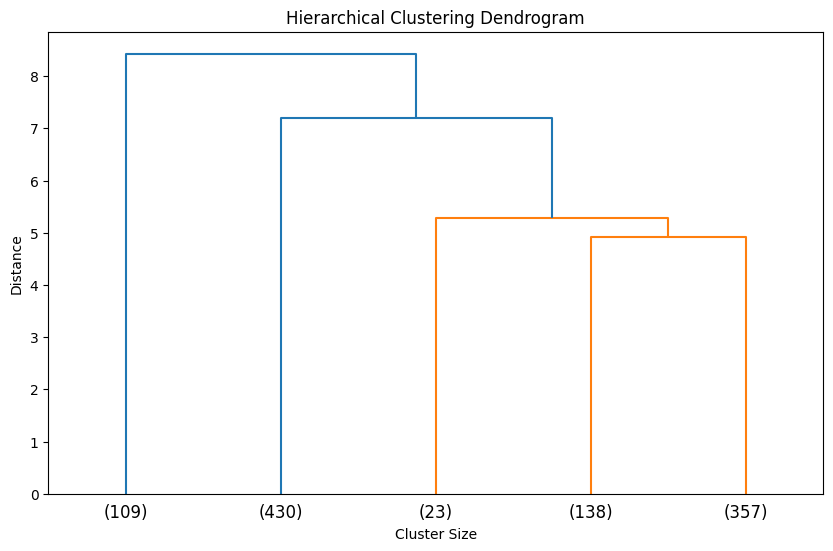

In [113]:
Z = linkage(X, method="ward")

plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode="lastp", p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()


### SIMILARITY MATRIX (FOR RECOMMENDATION)

In [114]:
similarity_matrix = cosine_similarity(X)

pickle.dump(similarity_matrix, open("similarity.pkl", "wb"))


### ALGORITHM COMPARISON (DECISION)

In [115]:
results = {
    "Algorithm": ["KMeans", "GMM"],
    "Silhouette": [
        silhouette_score(X, kmeans_labels),
        silhouette_score(X, gmm_labels)
    ],
    "Davies-Bouldin": [
        davies_bouldin_score(X, kmeans_labels),
        davies_bouldin_score(X, gmm_labels)
    ],
    "Calinski-Harabasz": [
        calinski_harabasz_score(X, kmeans_labels),
        calinski_harabasz_score(X, gmm_labels)
    ]
}

pd.DataFrame(results)


,Algorithm,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,KMeans,0.075593,3.243613,57.281948
1,GMM,0.074600,3.276692,56.706924


In [116]:
data.to_csv("final_clustered_dataset.csv", index=False)


### KMeans — Plotting clusters with PCA components + elbow method for clusters

Scatter plot of data points colored by cluster

Elbow curve to find optimal number of clusters

Silhouette plot

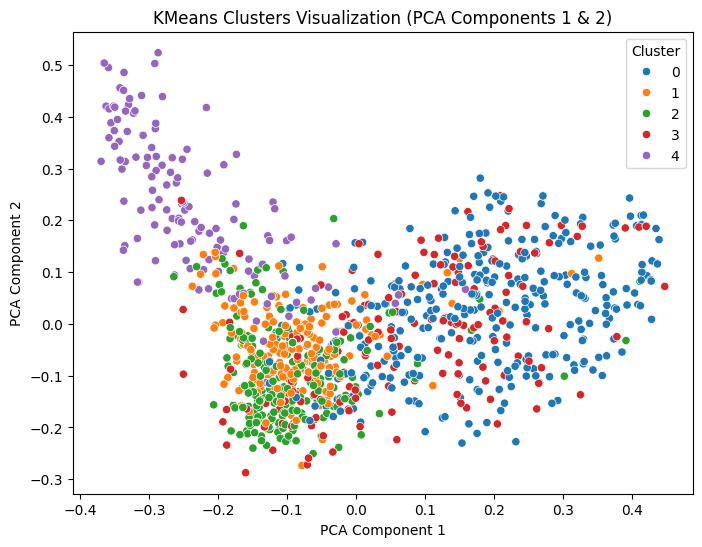

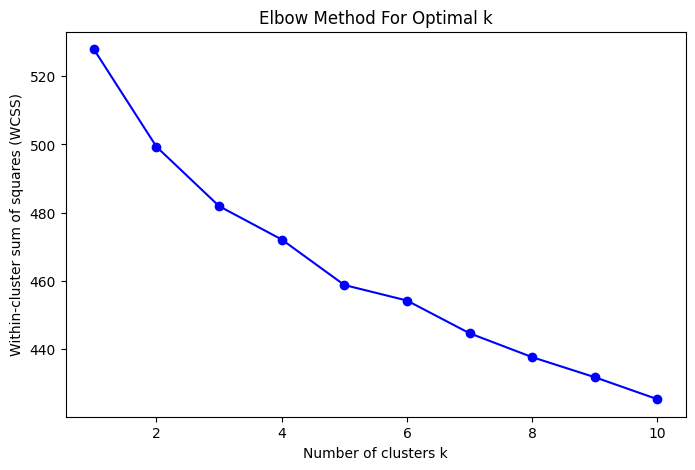

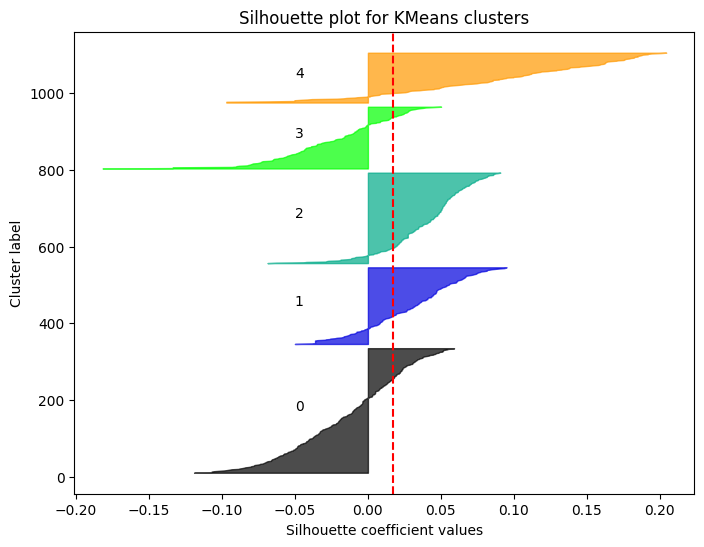

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
import numpy as np

# Assuming X_pca and kmeans_labels are from previous step

# Scatter plot of first two PCA components colored by cluster
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=kmeans_labels, palette='tab10')
plt.title("KMeans Clusters Visualization (PCA Components 1 & 2)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Elbow method (run once separately to choose k)
wcss = []
K = range(1, 11)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_pca)
    wcss.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, wcss, 'bo-')
plt.xlabel('Number of clusters k')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.title('Elbow Method For Optimal k')
plt.show()

# Silhouette plot for KMeans
silhouette_vals = silhouette_samples(X_pca, kmeans_labels)
y_lower = 10
plt.figure(figsize=(8,6))
for i in range(len(np.unique(kmeans_labels))):
    ith_cluster_silhouette_vals = silhouette_vals[kmeans_labels == i]
    ith_cluster_silhouette_vals.sort()
    size_cluster_i = ith_cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / len(np.unique(kmeans_labels)))
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_vals, facecolor=color, edgecolor=color, alpha=0.7)

    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10  # 10 for spacing between clusters

plt.xlabel("Silhouette coefficient values")
plt.ylabel("Cluster label")
plt.title("Silhouette plot for KMeans clusters")
plt.axvline(x=silhouette_score(X_pca, kmeans_labels), color="red", linestyle="--")
plt.show()


### GMM — Plot clusters with confidence ellipses

TypeError: __init__() takes 4 positional arguments but 5 were given

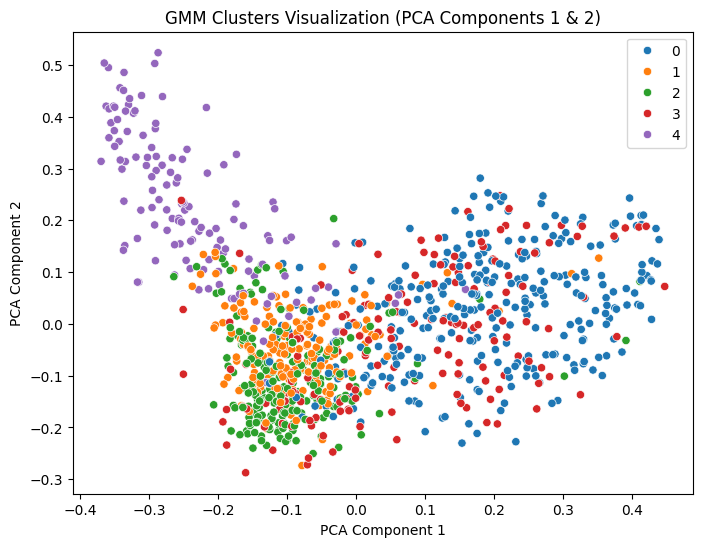

In [125]:
import matplotlib.patches as patches

# Scatter plot colored by GMM cluster
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=gmm_labels, palette='tab10')
plt.title("GMM Clusters Visualization (PCA Components 1 & 2)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")

# Draw ellipses around clusters (covariance)
def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    for nsig in range(1, 4):
        ax.add_patch(patches.Ellipse(position, nsig*width, nsig*height,
                                     angle, **kwargs))

ax = plt.gca()
for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
    draw_ellipse(pos[:2], covar[:2, :2], ax=ax, alpha=0.3, color='k')

plt.legend(title="Cluster")
plt.show()


### DBSCAN — Plot clusters including noise points

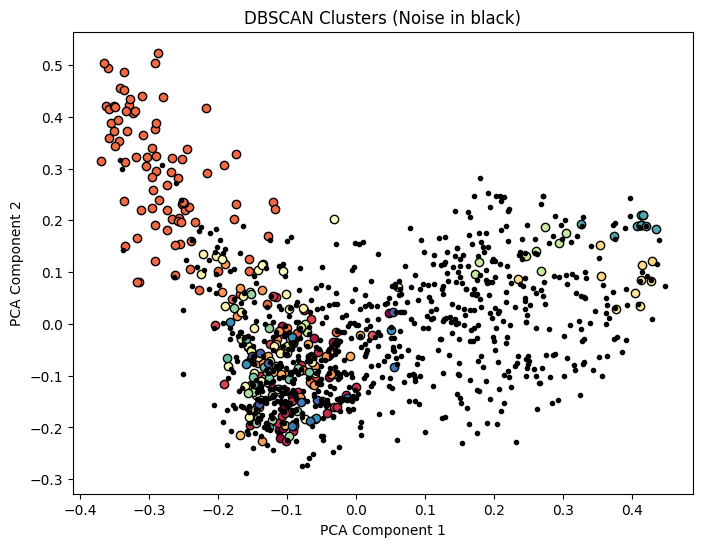

In [122]:
plt.figure(figsize=(8,6))
unique_labels = set(dbscan_labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black color for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (dbscan_labels == k)
    xy = X_pca[class_member_mask]

    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6 if k != -1 else 3)

plt.title("DBSCAN Clusters (Noise in black)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


### Hierarchical Clustering — Dendrogram plot (you already have this but here it is again)

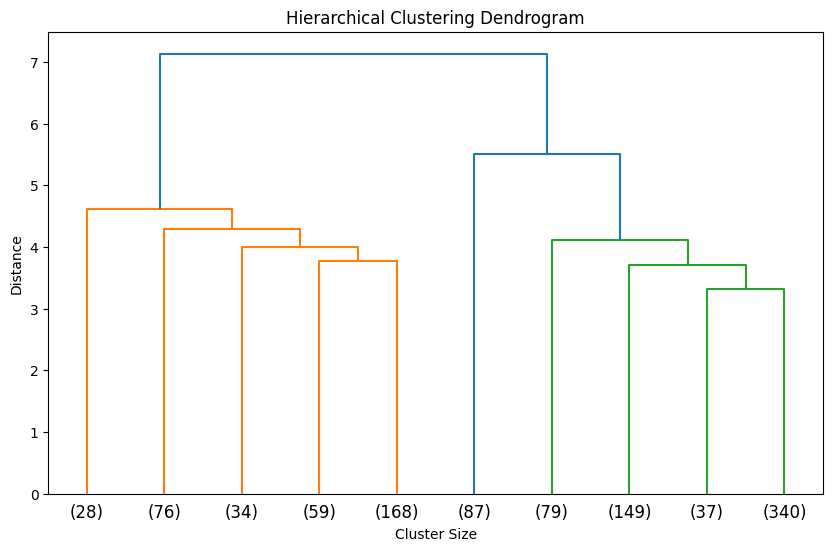

In [123]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X_pca, method="ward")

plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode="lastp", p=10)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Cluster Size")
plt.ylabel("Distance")
plt.show()
